# Multi Layer Perceptron (MLP)

MLP is one of the most popular and well known deep architectures. The functional form is 

$$
f(x; W, b) = g_D(W_D \dots g_3(W_3 g_2( W_2 g_1(W_1 x + b_1) + b_2 ) + b_3 ) \dots + b_D)
$$

For a $D$ layer network, at layer $i$, we have the weight matrix $W_i$, the bias vector $b_i$ and the (very often nonlinear) function $g_i$, that applies elementwise to its argument


In [21]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import scipy as sc


In [328]:
import torch
import torch.autograd
from torch.autograd import Variable

sizes = [2,20,10,20,3,4]

# Generate data from a Waring decomposition
N = 100
rank = 6
order = 2
U1 = np.random.randn(rank, sizes[0])
U2 = np.random.randn(sizes[-1],rank)/10
x = np.random.randn(sizes[0],N)
y = np.tanh(U2.dot(U1.dot(x)**order))

g = torch.nn.Tanh()
Error = torch.nn.MSELoss(size_average=True)

# Generate the network
D = len(sizes)
Weight = []
Bias = []
Func = []
for i in range(D-1):
    W = Variable(torch.randn(sizes[i+1],sizes[i]).double(), requires_grad=True)
    b = Variable(torch.randn(sizes[i+1],1).double(), requires_grad=True)
    Weight.append(W)
    Bias.append(b)
    Func.append(g)

In [320]:

#def mlp_fun(x, Weight, Bias, Func):
    

eta = 0.005
MAX_ITER = 10000
BatchSize = 100
EE = []
for epoch in range(MAX_ITER):
    idx = np.random.choice(N, size=BatchSize, replace=False)
    #idx = [epoch%N]
    f = Variable(torch.DoubleTensor(x[:,idx]), requires_grad=False)
    for i in range(D-1):
        f = g(torch.matmul(Weight[i], f) + Bias[i])
        
    E = Error(f, Variable(torch.DoubleTensor(y[:,idx])))
    EE.append(E.data.numpy())
    E.backward() 
    
    for i in range(D-1):
        Weight[i].data.add_(-eta*Weight[i].grad.data)
        Bias[i].data.add_(-eta*Bias[i].grad.data)
        Weight[i].grad.zero_()
        Bias[i].grad.zero_()
    
    

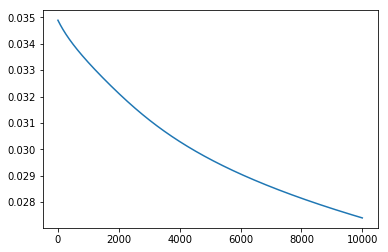

In [321]:
plt.plot(EE)
plt.show()

In [322]:
idx = [18]
f = Variable(torch.DoubleTensor(x[:,idx]), requires_grad=False)
torch.matmul(Weight[0], f)

Variable containing:
 0.5329
-1.4695
 1.5401
 0.2610
 0.8867
-0.0026
-0.5196
 1.2506
-0.9792
 0.7922
 0.7443
 0.2446
 1.4341
-0.8934
 0.5749
 0.3045
 0.5889
-2.3111
 1.3216
 0.4096
[torch.DoubleTensor of size 20x1]

In [325]:
idx = [1]
f = Variable(torch.DoubleTensor(x[:,idx]), requires_grad=False)
for i in range(D-1):
    #print(f)
    f = g(torch.matmul(Weight[i], f) + Bias[i])

print(f)
print(y[:,idx])

Variable containing:
-0.9035
 0.8587
 0.7793
-0.6354
[torch.DoubleTensor of size 4x1]

[[-0.89082718]
 [ 0.99662228]
 [ 0.52026339]
 [-0.78996949]]


In [163]:
idx = range(10)
f = Variable(torch.DoubleTensor(x[:,idx]), requires_grad=False)
i = 0
torch.matmul(Weight[i], f)

#f = g(torch.mm(Weight[i], f) + Bias[i])
f

Variable containing:
-1.3209 -1.1514  0.5652 -0.5197  0.1485 -2.0634 -1.1099  1.3475 -0.6163  0.2242
 0.7550  1.2839  0.6789  2.1288  0.2809 -0.1979 -0.5285  0.0090 -0.1808 -1.8460
-1.1613  0.7516 -0.5483 -0.5283 -0.6651  0.4904 -1.3772 -0.8368 -1.2510  0.4022
[torch.DoubleTensor of size 3x10]

In [165]:
g(torch.mm(Weight[i], f).transpose(-1,0) + Bias[i])

Variable containing:

Columns 0 to 9 
 0.7469 -0.9551  0.9961  0.3624  0.9757 -0.0178 -0.9434  0.9629  0.4486  0.9995
-0.6732  0.4722  0.9850 -0.5244  0.9054  0.0314 -0.9669  0.0204  0.9631  0.5500
 0.4719 -0.6089  0.0709 -0.5079  0.9563 -0.6942 -0.3735 -0.9716  0.4458  0.7643
 0.7537 -0.7161  0.9802  0.6725  0.9982 -0.1459 -0.9956  0.2194  0.8836  0.9978
 0.3926 -0.7413  0.5073 -0.5968  0.8957 -0.6260 -0.1179 -0.8687  0.2898  0.8554
-0.8582 -0.0450  0.9970 -0.8704 -0.2185  0.1987 -0.5361  0.9245  0.8617  0.5640
 0.5850 -0.9722  0.9810 -0.4774  0.6759 -0.3060  0.0988  0.9035 -0.2978  0.9967
 0.5556 -0.7152 -0.8572 -0.7888  0.8827 -0.8655  0.7451 -0.9981 -0.1850  0.1866
 0.6324 -0.9523  0.9351 -0.4264  0.8378 -0.4455 -0.0563  0.4886 -0.1574  0.9924
-0.9248  0.3207 -0.6821 -0.9960 -0.9547 -0.7916  0.9957 -0.9946  0.0055 -0.9950

Columns 10 to 19 
 0.7519 -0.9565 -0.7985 -0.2928  0.9984 -0.9349  0.4765  0.1362  0.2425 -0.9931
-0.9892 -0.9949 -0.6197 -0.9541  0.9931 -0.9401  0.9079 -0.2460

In [327]:
Variable(torch.DoubleTensor(y[:,idx]))

Variable containing:
-0.8908
 0.9966
 0.5203
-0.7900
[torch.DoubleTensor of size 4x1]

In [247]:
A = torch.DoubleTensor([[1,2,3],[4,5,6]])
T = torch.rand([3,5,2])
u = torch.DoubleTensor([[7],[8]])
w = torch.rand([5,3]).double()